This notebook reproduces the analyses shown in the paper "Lipid shape and packing are key for optimal design of pH sensitive mRNA lipid nanoparticles" 

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [125]:
import numpy as np
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from jinja2 import Template
import pandas as pd
from pathlib import Path
from io import StringIO 
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import os
from scipy.optimize import curve_fit
gaussian = lambda x,u,s,a : a/(s*np.sqrt(2*np.pi))*np.exp(-(x-u)**2/2/s**2)
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir

/Users/vbr805/Dropbox/LNPS/SI-LNPs


In [126]:
!mkdir figs

mkdir: figs: File exists


Bead sizes of the CG lipid models

In [127]:
L = pd.Series({'HD':2.5,'T1':3.5,'T2':4.1})
L1 = pd.Series({'HD':2.3,'T1':3.58,'T2':4.1})
L2 = pd.Series({'HD':2.2,'T1':3.62,'T2':4.1})
L3 = pd.Series({'HD':2.1,'T1':3.65,'T2':4.1})
L4 = pd.Series({'HD':2.0,'T1':3.68,'T2':4.1})
L5 = pd.Series({'HD':2.2,'T1':3.55,'T2':4.15})
M = pd.Series({'HD':2,'T1':3.4,'T2':4.3})
S = pd.Series({'HD':1.8,'T1':3.3,'T2':4.4})
models = pd.DataFrame({'L':L,'L1':L1,'L2':L2,'L3':L3,'L4':L4,'L5':L5,'M':M,'S':S})
models

,L,L1,L2,L3,L4,L5,M,S
HD,2.5,2.30,2.20,2.10,2.00,2.20,2.0,1.8
T1,3.5,3.58,3.62,3.65,3.68,3.55,3.4,3.3
T2,4.1,4.10,4.10,4.10,4.10,4.15,4.3,4.4


Molecular volumes

In [128]:
(4/3*np.pi*models**3).sum()

L     533.739837
L1    531.853675
L2    532.005376
L3    531.176821
L4    530.958614
L5    531.390973
M     531.184675
S     531.779483
dtype: float64

Critical packing parameter

In [129]:
models.loc['l'] = models.sum(axis=0)+models.loc['T1']
models.loc['a'] = np.pi*models.loc['HD']**2
models.loc['v'] = 1/3 * np.pi * models.loc['l'] * (models.loc['HD']**2 + models.loc['HD'] * models.loc['T2'] + models.loc['T2']**2)

In [130]:
[round(i,1) for i in (models.loc['v']/models.loc['l']/models.loc['a']).values]

[1.8, 2.0, 2.1, 2.3, 2.4, 2.1, 2.6, 3.1]

### Load the simulation data and save it to pickle files

In [131]:
nskip = 500 # skip the first 500 frames for equilibration
maxrows = 6000
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
obs = ['S/nm2','b/nm','d/nm','alpha','[Cl]/M','[Na]/M','lipids','phi','PP',
       'nu/nm3','Lz/nm','N/P','l_P/nm','r_P/nm','r_P-HD/nm','r_Cl/nm','cos_theta']

In [132]:
def make_table(models,path,model,pKa,nskip,pHs,max_rows=4000):
    index = pd.MultiIndex(levels=[obs,['AVG', 'SD']],
                  codes=[np.repeat(range(len(obs)),2),[0, 1]*len(obs)])
    table = pd.DataFrame(index=index,columns=pHs).T
    for pH in table.index:
        aL = 3e-3/(1+10**(pKa-pH))
        current_path = path.format(model,pKa,pH,aL)
        cos_theta = np.loadtxt(current_path+'/order.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        c = np.loadtxt(current_path+'/NHHD.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        z = np.loadtxt(current_path+'/Nlipids.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        table.loc[pH]['alpha','AVG'] = (c/z).mean()
        table.loc[pH]['alpha','SD'] = (c/z).std()
        table.loc[pH]['cos_theta','AVG'] = (cos_theta).mean()
        table.loc[pH]['cos_theta','SD'] = (cos_theta).std()
        table.loc[pH]['lipids','AVG'] = z.mean()
        table.loc[pH]['lipids','SD'] = z.std()
        
        y = np.loadtxt(current_path+'/Rcyl.dat',usecols=1,skiprows=nskip,max_rows=max_rows)     
        diff = models[model]['HD']/2
        b = y.mean()
        b_error = y.std()
        
        table.loc[pH]['b/nm','AVG'] = b/10 
        table.loc[pH]['b/nm','SD'] = b_error/10
        l = np.loadtxt(path.format(model,pKa,pH,aL)+'/Lz.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        s = 2*np.pi*b*l/z#/(np.pi*models[model]['HD']**2)
        table.loc[pH]['Lz/nm','AVG'] = l.mean()/10
        table.loc[pH]['Lz/nm','SD'] = l.std()/10
        table.loc[pH]['S/nm2','AVG'] = s.mean()/100
        s_error = s.mean()*np.sqrt((b_error/b)**2+(l.std()/l.mean())**2+(z.std()/z.mean())**2)/100 
        table.loc[pH]['S/nm2','SD'] = s_error
        d = np.loadtxt(current_path+'/radius.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        table.loc[pH]['d/nm','AVG'] = (d*2).mean()/10 
        table.loc[pH]['d/nm','SD'] = (d*2).std()/10 
        V = 2*np.sqrt(3)*d*d*l
        phi = 2*np.pi*b*b/(4*d*d*np.sqrt(3))
        nu = s*d*(1-phi)/np.sqrt(phi*2*np.pi/np.sqrt(3))
        pp = (1-phi)/(np.sqrt(phi*2*np.pi/np.sqrt(3))-2*phi)
        table.loc[pH]['phi','AVG'] = phi.mean()
        table.loc[pH]['phi','SD'] = phi.std()
        table.loc[pH]['PP','AVG'] = pp.mean()
        table.loc[pH]['PP','SD'] = pp.std()
        table.loc[pH]['nu/nm3','AVG'] = nu.mean()/1e3
        table.loc[pH]['nu/nm3','SD'] = nu.std()/1e3
        if os.path.isfile(current_path+'/RMP.dat'):
            p = np.loadtxt(current_path+'/RMP.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
            rp = p.mean()
            rp_error = p.std()
            table.loc[pH]['r_P-HD/nm','AVG'] = (b-rp)/10
            table.loc[pH]['r_P-HD/nm','SD'] = (b_error+rp_error)/10
            table.loc[pH]['r_P/nm','AVG'] = rp/10
            table.loc[pH]['r_P/nm','SD'] = rp_error/10
            x,h = np.loadtxt(current_path+'/distCl.dat',usecols=(0,1),unpack=True)
            h = h[x<20]
            x = x[x<20]
            popt,_ = curve_fit(gaussian,x,h,p0=[x[h.argmax()],2,100])
            rc = popt[0]
            rc_error = popt[1]
            table.loc[pH]['r_Cl/nm','AVG'] = rc/10
            table.loc[pH]['r_Cl/nm','SD'] = rc_error/10
            table.loc[pH]['N/P','AVG'] = (z/72).mean()
            table.loc[pH]['N/P','SD'] = (z/72).std()
            table.loc[pH]['l_P/nm','AVG'] = l.mean()/72/10
            table.loc[pH]['l_P/nm','SD'] = l.std()/72/10 
        n = np.loadtxt(current_path+'/NCl.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        conc = n/V/phi/6.022*1e4
        table.loc[pH]['[Cl]/M','AVG'] = conc.mean()
        table.loc[pH]['[Cl]/M','SD'] = conc.std()
        n = np.loadtxt(current_path+'/NNa.dat',usecols=1,skiprows=nskip,max_rows=max_rows)
        conc = n/V/phi/6.022*1e4
        table.loc[pH]['[Na]/M','AVG'] = conc.mean()
        table.loc[pH]['[Na]/M','SD'] = conc.std()
    return table

In [133]:
#writer = pd.to_excel('data_cg_models_rna.xlsx', engine='xlsxwriter')
path = 'data/rna_310/{:s}_{:.2f}_{:.1f}_{:.2g}'
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
for model,pKa in zip(['L','M','S','L'],[9.41,9.41,9.41,8.46]):
    table = make_table(models,path,model,pKa,nskip,pHs)
    table.to_pickle(model+'_{:.2f}_rna.pkl'.format(pKa))
    #table.to_excel(writer, 
    #        sheet_name=model+' '+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [134]:
#writer = pd.ExcelWriter('data_cg_models_empty_310.xlsx', engine='xlsxwriter')
path = 'data/norna_310/{:s}_{:.2f}_{:.1f}_{:.2g}'
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
for model,pKa in zip(['L','S','L','M'],[8.46,9.41,9.41,9.41]):
    table_310 = make_table(models,path,model,pKa,nskip,pHs)
    table_310.to_pickle(model+'_{:.2f}_empty_310.pkl'.format(pKa))
    #table_310.to_excel(writer, 
    #        sheet_name=model+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [135]:
#writer = pd.ExcelWriter('data_cg_models_empty_298.xlsx', engine='xlsxwriter')
path = 'data/norna_298/{:s}_{:.2f}_{:.1f}_{:.2g}'
pHs = [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]
for model,pKa in zip(['L','S','L','M'],[8.46,9.41,9.41,9.41]):
    table_298 = make_table(models,path,model,pKa,nskip,pHs)
    table_298.to_pickle(model+'_{:.2f}_empty_298.pkl'.format(pKa))
    #table_298.to_excel(writer, 
    #        sheet_name=model+' '.join(map(str, models[model].values))+' pKa={:.2f}'.format(pKa))
#writer.save()

In [136]:
dd_empty = pd.read_pickle('L_8.46_empty_298.pkl')
dd_empty.loc[3,['d/nm','phi','b/nm','S/nm2']]

d/nm   AVG    7.508748
       SD     0.035664
phi    AVG    0.332943
       SD     0.003164
b/nm   AVG    2.274721
       SD     0.070448
S/nm2  AVG     0.42524
       SD     0.013776
Name: 3.0, dtype: object

In [137]:
mc3_empty = pd.read_pickle('M_9.41_empty_298.pkl')
mc3_empty.loc[3,['d/nm','phi','b/nm','S/nm2']]

d/nm   AVG    7.844911
       SD     0.040664
phi    AVG    0.330365
       SD     0.003424
b/nm   AVG    2.367324
       SD     0.019217
S/nm2  AVG    0.405442
       SD     0.005338
Name: 3.0, dtype: object

### Fig. 1

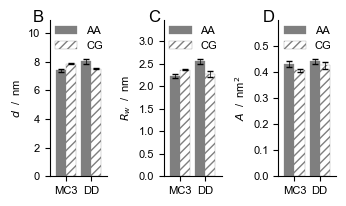

In [138]:
A = {('value','MC3'):[0.43,0.405442],('value','DD'):[0.44,0.42524],
     ('error','MC3'):[0.01,0.005338],('error','DD'):[0.01,0.013776]}
df_A = pd.DataFrame(A,index=['AA','CG'])
d = {('value','MC3'):[7.39,7.844911],('value','DD'):[8.02,7.508748],
     ('error','MC3'):[0.13,0.040664],('error','DD'):[0.15,0.035664]}
df_d = pd.DataFrame(d,index=['AA','CG'])
Rw = {('value','MC3'):[2.22,2.367324],('value','DD'):[2.55,2.274721],
     ('error','MC3'):[0.04,0.019217],('error','DD'):[0.05,0.070448]}
df_Rw = pd.DataFrame(Rw,index=['AA','CG'])

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(3.5,2))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

labels = ['$d$  /  nm','$R_w$  /  nm','$A$  /  nm$^2$']

for ax,df,l in zip([ax1,ax2,ax3],[df_d,df_Rw,df_A],labels):
    df.value.T.plot.bar(ax=ax,hatch='////',color=['tab:grey','w'],lw=.2,width=.8,edgecolor='tab:grey',
                       yerr=df.error.T,error_kw=dict(ecolor='k',elinewidth=0.5,capsize=2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis='x',rotation=0)
    ax.set_ylabel(l)
    ax.legend(frameon=False,loc='upper left',borderpad=0)
    ax.set_ylim(0,df.value.values.max()*1.36)
    
fig.text(0.1, .93, 'B', fontsize=12)
fig.text(0.43, .93, 'C', fontsize=12)
fig.text(0.755, .93, 'D', fontsize=12)
plt.tight_layout()
plt.savefig('figs/fig1.pdf')
plt.show()

### Fig. 2

L 9.41
-7.554213400724129
M 9.41
2.5160546280905396
S 9.41
5.949929694090589


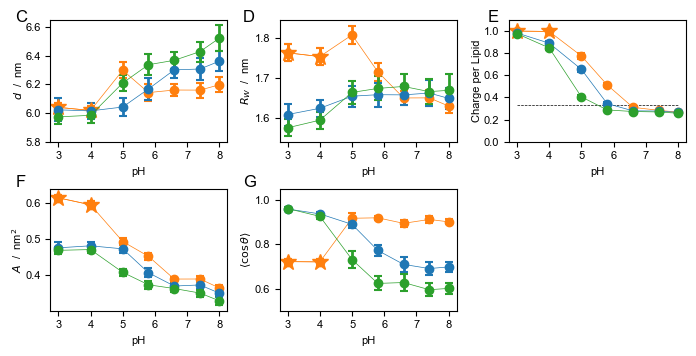

In [139]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(7,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
path = 'lnps_rna/{:s}_{:.2f}_{:.1f}_{:.2g}'
colors = ['tab:orange','tab:blue','tab:green']
for model,pKa,c in zip(['L','M','S'],[9.41,9.41,9.41],colors):
    print(model,pKa)
    table = pd.read_pickle('{:s}_{:.2f}_rna.pkl'.format(model,pKa))
    for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','cos_theta']):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color=c)
        if o == 'b/nm':
            print(100*(table[o].AVG.values[-1]-table[o].AVG.values[0])/table[o].AVG.values[0])
        
    if model == 'L':
        for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','cos_theta']):
            ax.errorbar(table.index[:2],table[o].AVG.values[:2],table[o].SD.values[:2],
                lw=0.5, marker='*', ms=12, 
                elinewidth=2, capsize=3, capthick=1.5, color=c)
        
axes.flatten()[0].set_ylabel(r'$d$  /  nm',labelpad=1)
axes.flatten()[1].set_ylabel(r'$R_W$  /  nm',labelpad=1)
axes.flatten()[2].set_ylabel(r'Charge per Lipid',labelpad=1)
axes.flatten()[3].set_ylabel(r'$A$  /  nm$^2$',labelpad=1)
axes.flatten()[4].set_ylabel(r'$\langle \cos{\theta} \rangle$',labelpad=1)
for ax in axes.flatten():
    ax.set_xlabel('pH')
    ax.set_xticks(range(3,9,1))
axes.flatten()[0].set_yticks([5.8,6,6.2,6.4,6.6])
axes.flatten()[1].set_yticks([1.6,1.7,1.8])
#axes.flatten()[2].set_yticks([.3,.4,.5,.6])
axes.flatten()[2].set_yticks([0,.2,.4,.6,.8,1])
#axes.flatten()[0].set_ylim(5.8,7)
#axes.flatten()[3].set_ylim(.5,1)
axes.flatten()[2].set_ylim(0,1.1)
axes.flatten()[4].set_ylim(.5,1.05)
#axes.flatten()[4].set_axis_off()
axes.flatten()[5].set_axis_off()
axes.flatten()[2].hlines(1/3,3,8,ls='--',color='k',lw=.5,zorder=0)
fig.text(0.025, .96, 'C', fontsize=12)
fig.text(0.35, .96, 'D', fontsize=12)
fig.text(0.7, .96, 'E', fontsize=12)
fig.text(0.025, .49, 'F', fontsize=12)
fig.text(0.35, .49, 'G', fontsize=12)
plt.tight_layout()
plt.savefig('figs/fig2.pdf')

### Fig. 3

In [ ]:
def writePQRAtom(line,ofh):
    spl = line.split()
    aname=spl[2]
    if not aname[0].isdigit():
        #print "change aname\"%s\""%aname
        aname = " "+aname
        #print "to \"%s\""%aname
    if len(spl)==11:
        outline="ATOM  %5d %-4s%1s%3s %1s%4d%1s   %8.3f%8.3f%8.3f%6.2f%6.2f      %4s%2s%2s%s\n" % (
            int(spl[1]),aname," ",spl[3],spl[4],int(spl[5])," ",float(spl[6]),float(spl[7]),
            float(spl[8]),float(spl[9]),float(spl[10]),"    ","  ","  ","")
    elif len(spl)==10:
        outline="ATOM  %5d %-4s%1s%3s %1s%4d%1s   %8.3f%8.3f%8.3f%6.2f%6.2f      %4s%2s%2s%s\n" % (
            int(spl[1]),aname," ",spl[3]," ",int(spl[4])," ",float(spl[5]),float(spl[6]),
            float(spl[7]),float(spl[8]),float(spl[9]),"    ","  ","  ","")
    else:
        raise ValueError("The format of this pqr is not as expected")
    ofh.write(outline)
    
def hex_to_vmd(color):
    h = mpl.colors.to_hex(color).lstrip('#')
    rgb = np.array([ int(h[i:i+2], 16) for i in (0, 2 ,4)])
    return ' '.join(['{:1.2f}'.format(i/255.) for i in rgb])

for folder in ['rna_310','norna_310']:
    path = f'data/{folder:s}'+'/{:s}_{:.2f}_{:.1f}_{:.2g}'
    for model,pKa in zip(['S','M','L','L'],[9.41,9.41,9.41,8.46]):
        l = []
        for pH in [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]:
            aL = 3e-3/(1+10**(pKa-pH))
            current_path = path.format(model,pKa,pH,aL)
            ifname = current_path+'/cuboid_4000000.pqr'
            ofname = current_path+'/cuboid_4000000.pdb'
            with  open(ifname,"r") as ifhandle:
                with open(ofname,"w") as ofhandle:
                    for line in ifhandle:
                        if line.startswith("ATOM"):
                            writePQRAtom(line,ofhandle)
                        else:
                            ofhandle.write(line)
            s = md.load_pdb(ofname)
            index_1 = s.top.select('name T1')
            index_2 = s.top.select('name T2')
            d = md.compute_distances(s,np.c_[index_1,index_2])
            l.append(d[d<3].mean())


colors = ['tab:green','tab:blue','tab:orange','tab:red']
vmd_path = 'csh /Applications/VMD_1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh'

for folder in ['rna_310','norna_310']:
    path = f'data/{folder:s}'+'/{:s}_{:.2f}_{:.1f}_{:.2g}'
    script_path = f'../snapshot.vmd'
    for pH in [3.0, 4.0, 5.0, 5.8, 6.6, 7.4, 8.0]:
        for model,pKa,color in zip(['S','M','L','L'],[9.41,9.41,9.41,8.46],colors):
            aL = 3e-3/(1+10**(pKa-pH))
            current_path = path.format(model,pKa,pH,aL)
            %cd {current_path}
            # Read in the file
            with open(script_path, 'r') as file :
                filedata = file.read()
            filedata = filedata.replace('new_box_color', hex_to_vmd(color))
            if folder == 'norna_310':
                half_box_length_y = md.load('confout.gro').unitcell_lengths[0][0]*np.sqrt(3)*10/2
                filedata = filedata.replace('half_box_length_y', f'{half_box_length_y:f}')
            with open('snapshot.vmd', 'w') as file:
                file.write(filedata)
            print(f'../{current_path.split("/")[-1]:s}.tga')
            !{vmd_path} -e snapshot.vmd -dispdev text
            !cp snapshot.tga ../{current_path.split('/')[-1]}.tga
            %cd -

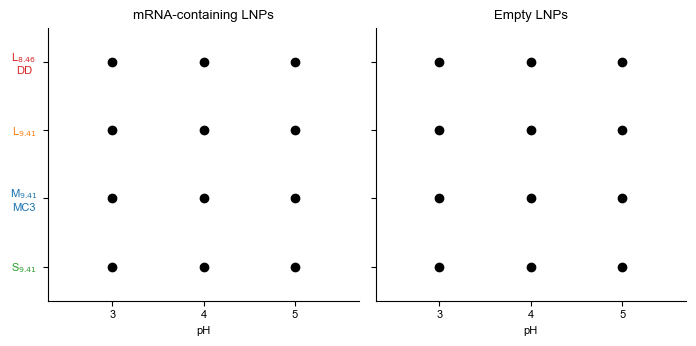

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(7,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

ax1.set_title('mRNA-containing LNPs')
ax2.set_title('Empty LNPs')

pHs = [3.0, 4.0, 5.0]
for ax in [ax1,ax2]:
    for i in range(1,5):
        ax.plot(pHs,[i]*len(pHs),marker='o',color='k',lw=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('pH')
    ax.set_ylim(.5,4.5)
    ax.set_xlim(2.3,5.7)
    ax.set_xticks(pHs)
    ax.set_yticks(range(1,5))
    ax.set_yticklabels(['S$_{9.41}$','M$_{9.41}$\nMC3','L$_{9.41}$','L$_{8.46}$\nDD'],ha='center')
    ax.tick_params(axis='y', which='major', pad=14)
    
colors = ['tab:green','tab:blue','tab:orange','tab:red']
for color,ticklabel in zip(colors,ax1.get_yticklabels()):
    ticklabel.set_color(color)
plt.tight_layout()
plt.savefig('figs/fig3.pdf')

### Fig. 4

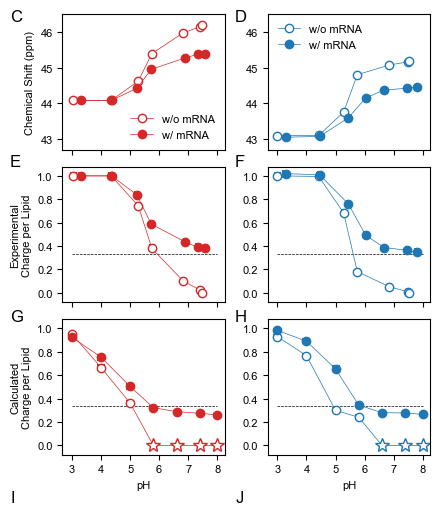

In [24]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, sharex=True, sharey=False, 
                                          figsize=(4.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

dd_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_empty')
ax1.plot(dd_empty.pH,dd_empty['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, mfc='w', color='tab:red',
            label='w/o mRNA')
dd_mRNA = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_mRNA')
ax1.plot(dd_mRNA.pH,dd_mRNA['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, color='tab:red',
            label='w/ mRNA')
      
mc3_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_empty')
ax2.errorbar(mc3_empty.pH,mc3_empty['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue',
            label='w/o mRNA')
mc3_mRNA = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_mRNA')
ax2.errorbar(mc3_mRNA.pH,mc3_mRNA['Shift (ppm)'],
            lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue',
            label='w/ mRNA')
      
dd_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_empty')
ax3.errorbar(dd_empty.pH,dd_empty['alpha'], 
            xerr=dd_empty['Error pH'],yerr=dd_empty['Error alpha'],
            lw=0.5, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
dd_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='DD_mRNA')
ax3.errorbar(dd_empty.pH,dd_empty['alpha'], 
            xerr=dd_empty['Error pH'],yerr=dd_empty['Error alpha'],
            lw=0.5, marker='o', ms=6,
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
      
mc3_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_empty')
ax4.errorbar(mc3_empty.pH,mc3_empty['alpha'],
            xerr=mc3_empty['Error pH'],yerr=mc3_empty['Error alpha'],
            lw=0.5, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue')
mc3_empty = pd.read_excel('data/NMR_data.xlsx',sheet_name='MC3_mRNA')
ax4.errorbar(mc3_empty.pH,mc3_empty['alpha'],
            xerr=mc3_empty['Error pH'],yerr=mc3_empty['Error alpha'],
            lw=0.5, marker='o', ms=6,
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue')

dd_empty = pd.read_pickle('L_8.46_empty_310.pkl')
ax5.errorbar(dd_empty.index,dd_empty['alpha'].AVG, 
            yerr=dd_empty['alpha'].SD,
            lw=0.5, color='tab:red')

ax5.errorbar(dd_empty.index[:3],dd_empty['alpha'].AVG.values[:3], 
            yerr=dd_empty['alpha'].SD.values[:3],
            lw=0, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
ax5.errorbar(dd_empty.index[3:],dd_empty['alpha'].AVG.values[3:], 
            yerr=dd_empty['alpha'].SD.values[3:],
            lw=0, marker='*', ms=10, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')
dd_mRNA = pd.read_pickle('L_8.46_rna.pkl')
ax5.errorbar(dd_mRNA.index,dd_mRNA['alpha'].AVG, 
            yerr=dd_mRNA['alpha'].SD,
            lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color='tab:red')

mc3_empty = pd.read_pickle('M_9.41_empty_310.pkl')
ax6.errorbar(mc3_empty.index,mc3_empty['alpha'].AVG, 
            yerr=mc3_empty['alpha'].SD,
            lw=0.5, color='tab:blue')
ax6.errorbar(mc3_empty.index[:4],mc3_empty['alpha'].AVG.values[:4], 
            yerr=mc3_empty['alpha'].SD.values[:4],
            lw=0, marker='o', ms=6, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue')
ax6.errorbar(mc3_empty.index[4:],mc3_empty['alpha'].AVG.values[4:], 
            yerr=mc3_empty['alpha'].SD.values[4:],
            lw=0, marker='*', ms=10, mfc='w',
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue')
mc3_mRNA = pd.read_pickle('M_9.41_rna.pkl')
ax6.errorbar(mc3_mRNA.index,mc3_mRNA['alpha'].AVG, 
            yerr=mc3_mRNA['alpha'].SD,
            lw=0.5, marker='o', ms=6,
            elinewidth=2, capsize=3, capthick=1.5, color='tab:blue')

ax1.legend(frameon=False,loc='lower right')
ax2.legend(frameon=False,loc='upper left')

#ax4.set_xlabel('pH')
ax5.set_xlabel('pH')
ax6.set_xlabel('pH')
ax1.set_ylabel('Chemical Shift (ppm)')
ax3.set_ylabel('Experimental\nCharge per Lipid')
ax5.set_ylabel('Calculated\nCharge per Lipid')
#ax1.set_title('NMR Experiments')
#ax2.set_title('NMR Experiments')
#ax3.set_title('Simulations')
ax1.set_ylim(42.7,46.5)
ax2.set_ylim(42.7,46.5)
ax5.set_xticks([3,4,5,6,7,8])

for ax in [ax3,ax4,ax5,ax6]:
    ax.hlines(1/3,3,8,ls='--',color='k',lw=.5,zorder=0)
    ax.set_ylim(-.08,1.08)

fig.text(0.04, .962, 'C', fontsize=12)
fig.text(0.54, .962, 'D', fontsize=12)
fig.text(0.04, .672, 'E', fontsize=12)
fig.text(0.54, .672, 'F', fontsize=12)
fig.text(0.04, .362, 'G', fontsize=12)
fig.text(0.54, .362, 'H', fontsize=12)
fig.text(0.04, 0, 'I', fontsize=12)
fig.text(0.54, 0, 'J', fontsize=12)

fig.tight_layout()
plt.savefig('figs/fig4.pdf')

### Fig. 5

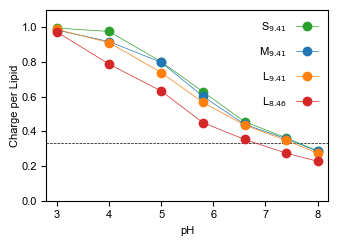

In [15]:
fig = plt.figure(figsize=(3.42,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
pb_data = pd.read_csv('data/PB_data.txt',delimiter=r'\s+')
colors = ['tab:green','tab:blue','tab:orange','tab:red']
labels = ['S$_{9.41}$','M$_{9.41}$','L$_{9.41}$','L$_{8.46}$']
for model,c,l in zip(pb_data.columns,colors,labels):
    plt.plot(pb_data.index, pb_data[model], lw=0.5, marker='o', ms=6, color=c, 
             label=l)
plt.hlines(1/3,2.8,8.2,ls='--',color='k',lw=.5,zorder=0)

        
plt.ylabel(r'Charge per Lipid',labelpad=1)
plt.xlabel('pH')
plt.legend(markerfirst=False,frameon=False,labelspacing=1,loc='upper right')
plt.ylim(0,1.1)
plt.xlim(2.8,8.2)
plt.tight_layout()
plt.savefig('figs/fig5.pdf',dpi=300)

### Fig. S4

L 9.41
M 9.41
S 9.41


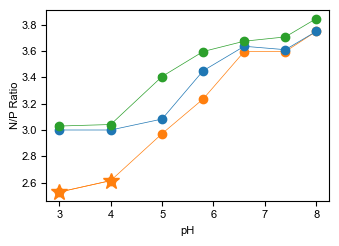

In [140]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(3.43,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
colors = ['tab:orange','tab:blue','tab:green']
for model,pKa,c in zip(['L','M','S'],[9.41,9.41,9.41],colors):
    print(model,pKa)
    table = pd.read_pickle('{:s}_{:.2f}_rna.pkl'.format(model,pKa))
    for o in ['N/P']:
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color=c)

        if model == 'L':
            ax.errorbar(table.index[:2],table[o].AVG.values[:2],table[o].SD.values[:2],
                lw=0.5, marker='*', ms=12, 
                elinewidth=2, capsize=3, capthick=1.5, color=c)
  
ax.set_ylabel(r'N/P Ratio',labelpad=1)
ax.set_xlabel('pH')
ax.set_xticks(range(3,9,1))
plt.tight_layout()
plt.savefig('figs/figS4.png',dpi=300)

### Fig. S5

L 8.46
-7.30299767349508
M 9.41
2.5160546280905396


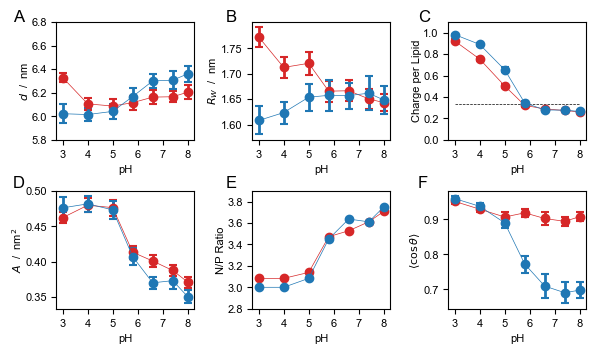

In [17]:
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(6,3.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})
colors = ['tab:red','tab:blue','tab:orange','tab:green']
#for model,pKa,c in zip(['L','M','L','S'],[8.46,9.41,9.41,9.41],colors):
for model,pKa,c in zip(['L','M'],[8.46,9.41],colors):
    print(model,pKa)
    table = pd.read_pickle('{:s}_{:.2f}_rna.pkl'.format(model,pKa))
    for ax,o in zip(axes.flatten(),['d/nm','b/nm','alpha','S/nm2','N/P','cos_theta']):
        ax.errorbar(table.index,table[o].AVG,table[o].SD,lw=0.5, marker='o', ms=6, 
            elinewidth=2, capsize=3, capthick=1.5, color=c)
        if o == 'b/nm':
            print(100*(table[o].AVG.values[-1]-table[o].AVG.values[0])/table[o].AVG.values[0])
        
        
axes.flatten()[0].set_ylabel(r'$d$  /  nm',labelpad=1)
axes.flatten()[1].set_ylabel(r'$R_W$  /  nm',labelpad=1)
axes.flatten()[2].set_ylabel(r'Charge per Lipid',labelpad=1)
axes.flatten()[3].set_ylabel(r'$A$  /  nm$^2$',labelpad=1)
axes.flatten()[4].set_ylabel(r'N/P Ratio',labelpad=1)
axes.flatten()[5].set_ylabel(r'$\langle \cos{\theta} \rangle$',labelpad=1)
for ax in axes.flatten():
    ax.set_xlabel('pH')
    ax.set_xticks(range(3,9,1))
axes.flatten()[0].set_yticks([5.8,6,6.2,6.4,6.6,6.8])
axes.flatten()[1].set_yticks([1.6,1.65,1.7,1.75])
#axes.flatten()[2].set_yticks([.3,.4,.5,.6])
axes.flatten()[2].set_yticks([0,.2,.4,.6,.8,1])
axes.flatten()[4].set_yticks(np.arange(2.8,3.9,.2))
axes.flatten()[4].set_ylim(2.8,3.9)
#axes.flatten()[3].set_ylim(.5,1)
axes.flatten()[2].set_ylim(0,1.1)
axes.flatten()[2].hlines(1/3,3,8,ls='--',color='k',lw=.5,zorder=0)
fig.text(0.025, .955, 'A', fontsize=12)
fig.text(0.38, .955, 'B', fontsize=12)
fig.text(0.7, .955, 'C', fontsize=12)
fig.text(0.025, .48, 'D', fontsize=12)
fig.text(0.38, .48, 'E', fontsize=12)
fig.text(0.7, .48, 'F', fontsize=12)
plt.tight_layout()
plt.savefig('figs/figS5.png',dpi=300)

### Fig. S7

51.58466899829135
53.061748164786


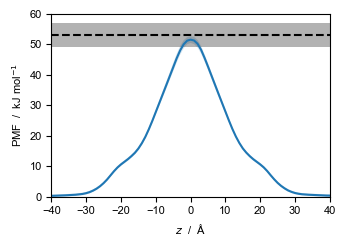

In [18]:
c = StringIO ("""-1.4661656804733727 0.7283026087431779
-1.3790650887573965 1.3083407975928765
-1.2892426035502957 2.688431660718038
-1.1994201183431952 4.458548202552464
-1.1095976331360946 6.9637131388774804
-1.019775147928994 9.813900790983766
-0.9299526627218935 13.099117084727325
-0.8442130177514793 16.54184374871886
-0.7666390532544378 19.99790462394833
-0.6972307692307691 23.534179113655938
-0.631905325443787 27.329428987250097
-0.5665798816568048 30.98029435478361
-0.5053372781065089 34.53981442256447
-0.4440946745562129 38.282025089850634
-0.3828520710059169 42.106741189171466
-0.32160946745562136 46.202546565177585
-0.24811834319526627 50.204060018858385
-0.16237869822485207 52.53671359729274
-0.0725562130177515 52.92673927600202
0.017266272189349063 53.061748164786
0.10708875739644963 52.56671557257807
0.20017751479289947 50.3195676237069
0.2704023668639053 46.98634816950681
0.3275621301775149 43.285390218237964
0.38063905325443814 39.67086652910068
0.43371597633136094 36.33136094674556
0.49087573964497055 32.818986840127366
0.5521183431952665 29.02079034396054
0.6174437869822489 25.287419544392364
0.6827692307692308 21.719059608893502
0.7521775147928995 18.14611603828162
0.829751479289941 14.528711207073272
0.9154911242603552 11.058982765324927
1.0053136094674557 7.5787536322267215
1.0951360946745563 4.803570918333762
1.1849585798816569 2.38841190786475
1.268656804733728 0.8245589461169516
""")
xE,yE = np.loadtxt(c,unpack=True)

fig = plt.figure(figsize=(3.5,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

x = np.arange(-68,69,1)
pmf = []
for i in range(20):
    p = np.loadtxt(f'data/Na_bilayer/{i:d}/penalty.dat')*8.3145*320/1e3
    if np.abs(p.min()-p.max())>40:
        pmf.append(p-(p[-20:-2].mean()+p[2:20].mean())/2)
mean = -np.mean(pmf,axis=0)[2:-2]
mean = mean-mean[-1:].mean()
err = np.std(pmf,axis=0)[2:-2]
plt.plot(x,mean)
print(mean.max())
plt.fill_between(x,mean-err,mean+err,lw=0,alpha=.2)
print(yE.max())
plt.ylim(0,60)
plt.xlim(-40,40)
plt.xlabel('$z$  /  Å')
plt.ylabel('PMF  /  kJ mol$^{-1}$')
plt.hlines(53,-40,40,color='k',ls='--')
plt.axhspan(49,57,-40,40,lw=0, alpha=0.3,color='k')
np.savetxt('data/Na_bilayer/profile.dat',np.c_[x,mean,err])
plt.tight_layout()
plt.savefig('figs/figS7.pdf')